In [1]:
# Modules and data loading
import numpy as np
import pandas as pd
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from pickle_fns import *
import math
from scipy.interpolate import griddata

vesdf,data_dfs=load_pkl('tikamgarh.pkl')
E,N=vesdf.Easting.values.astype(np.float),vesdf.Northing.values.astype(np.float)
# E,N,data_dfs[0]

In [17]:
#this is to digitize lithologies for better processing. It will be easier to plot them
def get_lables(df,lith_dict):
    labels=[]
    for s in df['Interpreted Lithology'].values:
        for i in range(len(lith_dict)):
            if s in lith_dict[i]:
#                 if i in labels and i!=labels[-1]:
#                     labels.append(i*10)
#                 else:
                    labels.append(i)
#                 break
    return labels

def str_array2floats(strarray):
    floats=[]
    for s in strarray:
        try:
            floats.append(float(s))
        except:
            floats.append(0)
    return floats

lith=[]
for df in data_dfs:
#     print(df.iloc[0])
    lith.extend(df['Interpreted Lithology'].values)
# data_dfs[0]
np.unique(np.array(lith)),np.array(lith) # you need to manually separate

#preparation of lith dictionary
fg_undersat=['Fractured Granite, may be under saturation',
        'Fractured granite , may be under saturation',
        'Fractured granite, may be under saturation',
        'Fractured/weathered granite, may be under saturation']
gran= ['Granite',]
hard_gran=['Hard Granite', 'Hard granite', ]
high_weath_gr =['Highly Weathered granite','Highly weathered Granite', 'Highly weathered granite','Soil with kankars/Highly weathered Granite',
        'Soil/Highly weathered Granite',]
soil_w_kankar= ['Overburden/top soil with kankars', 'Soil', 'Soil with kankars', 'Top Soil with kankars',
        'Top soil', 'Top soil with kankars', 'Top soils with kankars',]
weather_gran=[ 'Weathered Granite', 'Weathered granite']
lith_dict={0:soil_w_kankar,1:high_weath_gr,2:weather_gran,3:gran ,4:fg_undersat,5:hard_gran,}


#utilization of get labels
for df in data_dfs:
    df['lith_label']=get_lables(df,lith_dict)    
lith_labels=np.array(df['lith_label'].values)
# lith_labels

#construction of lith labels for layers or thicknesses

np.set_printoptions(precision=3, suppress=True)
master_l_thicknesses=[]
lith_labels=[]
max_strata_thickness=100
for df in data_dfs:
#     print(df['Thickness(m)'].values.astype(np.float))
    layers_values=str_array2floats(df['Thickness(m)'].values)
    lastlayer_thickness=[max_strata_thickness-np.nansum(layers_values) if math.isnan(x) else x for x in layers_values]
#     print(lastlayer_thickness)
    master_l_thicknesses.append(lastlayer_thickness)
    lith_labels.append(np.array(df['lith_label'].values))

# layers_values,np.nansum(layers_values),master_l_thicknesses,lith_labels

In [15]:
# from io import StringIO
# data = "1 2 3\n 4 5 6"
# data
# np.genfromtxt(data, dtype=( float))


In [18]:
def loggify(thicks_of_loc,labels,interval):
    rock_log=[]
    depth_log=[0]
    for layer,label in zip(thicks_of_loc,labels):
        for dt in np.arange(0,layer,interval):
            rock_log.append(label)
            depth_log.append(depth_log[-1]+interval)
#     depth_log=np.arange(0,sum(thicks_of_loc),interval)
    return pd.DataFrame({'Depth':depth_log[:-1],'Lithology':np.array(rock_log)})
        
        

In [226]:
# ldf=pd.DataFrame(columns={'Depth','Lithology','Loc_number'})
ldf=pd.DataFrame(columns={'Depth','Lithology'})
for ticks,lbls,v in zip(master_l_thicknesses,lith_labels,vesdf['VES No.'].values):
    lith_log=loggify(ticks,lbls,0.1)
    lith_log['Loc_number']=int(v)
    ldf=ldf.append(lith_log)

# ldf.head()

D:\adiarun\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [227]:
color_def={'top_soil':'#69656f','high_weath_gr':'#ded2cf','weather_gran':'#aca1a1','granite':'#2f353b',
           'frac_granite':'#f6ae99','hard_granite':'#a8224a',}
color_def={'top_soil':'#CCCCCC','high_weath_gr':'#FFFF80','weather_gran':'#ACACFF','granite':'#F07800',
           'frac_granite':'#FF99CC','hard_granite':'#B00600',}

lith_label_def={0:'Top soil/w kankar',1:'Highly weath. Granite',2:'Weath. Granite',3:'Granite' ,4:'Und.Sat Frac. Granite',5:'Hard Granite',}
# facies_colors = [ '#F5B041','#DC7633','#6E2C00','#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D','#F4D03F',]
facies_colors=[color_def[l] for l in color_def]
facies_labels=[lith_label_def[l] for l in lith_label_def]
facies_colors

['#CCCCCC', '#FFFF80', '#ACACFF', '#F07800', '#FF99CC', '#B00600']

In [228]:
vesdf['VES No.'].values.astype(np.int)

array([657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669,
       670, 671, 672, 673, 674])

In [231]:
from matplotlib import gridspec
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
def facies_log_plot_single(logs, facies_colors,facies_labels,Loc_number):
    logs=logs[logs['Loc_number']==Loc_number]
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
#     print(logs)
    cmap_facies = colors.ListedColormap( facies_colors[0:len(facies_colors)], 'indexed')
#     print(cmap_facies)
    ztop=logs.Depth.min(); zbot=logs.Depth.max()    
    cluster=np.repeat(np.expand_dims(logs['Lithology'].values.astype(np.int),1), 100, 1)
#     print(cmap_facies)
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(3, 12),sharey=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 5]) 
    ax[0] = plt.subplot(gs[0])


    
    ax[0].set_ylim(ztop,zbot)
    ax[0].invert_yaxis()
    ax[0].set_xticklabels([])
    ax[0].horizontalalignment = "left"
    
    ax[1] = plt.subplot(gs[1])    
    im=ax[1].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=6)    
    ax[1].set_xlabel('Layers')
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((11*' ').join(facies_labels[::-1]))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    cbar.ax.invert_yaxis() 
    f.suptitle('Location: %s'%Loc_number, fontsize=14,y=0.94)

# facies_log_plot_single(ldf, facies_colors[:len(facies_labels)],facies_labels,657)


# facies_colors=facies_colors[0:len(facies_labels)]

# logs=lith_log
# logs = logs.sort_values(by='Depth')
# cmap_facies = colors.ListedColormap(
#         facies_colors[0:len(facies_colors)+1], 'indexed')

# ztop=logs.Depth.min(); zbot=logs.Depth.max()    
# cluster=np.repeat(np.expand_dims(logs['Lithology'].values,1), 20, 1)
# # cmap_facies.facies_colors,cluster.shape

In [186]:
Loc_numbers=[657,658,659]
ncols=len(Loc_numbers)+1
figsize=(1+(ncols-1)*2,12)
width_ratios=[1]+[2 for r in range(ncols-1)]
figsize,width_ratios

((7, 12), [1, 2, 2, 2])

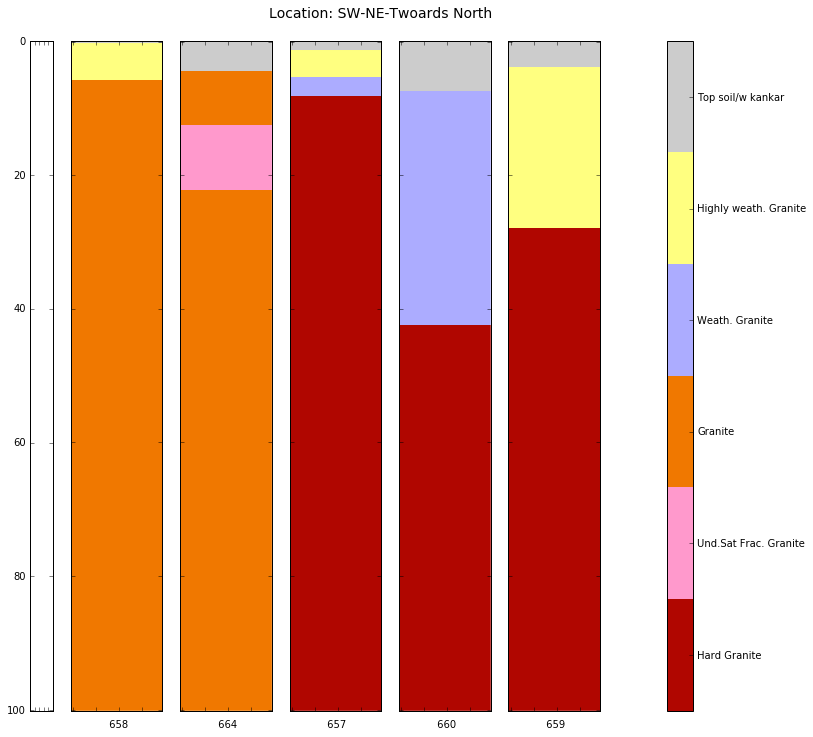

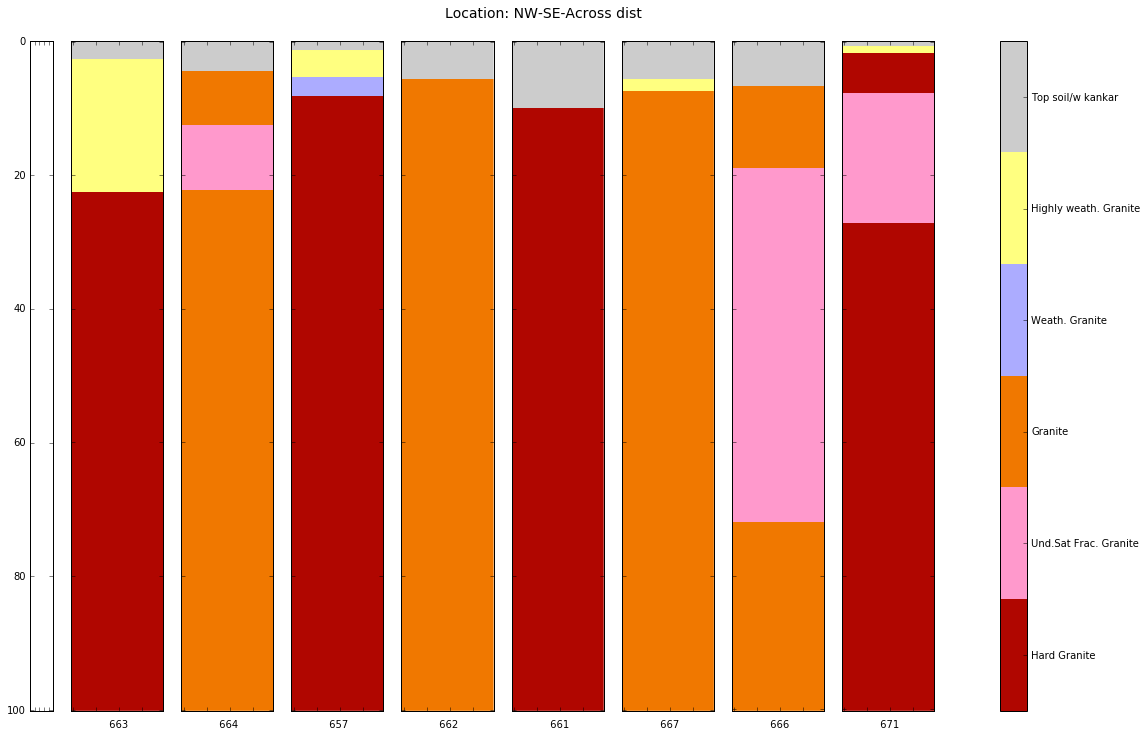

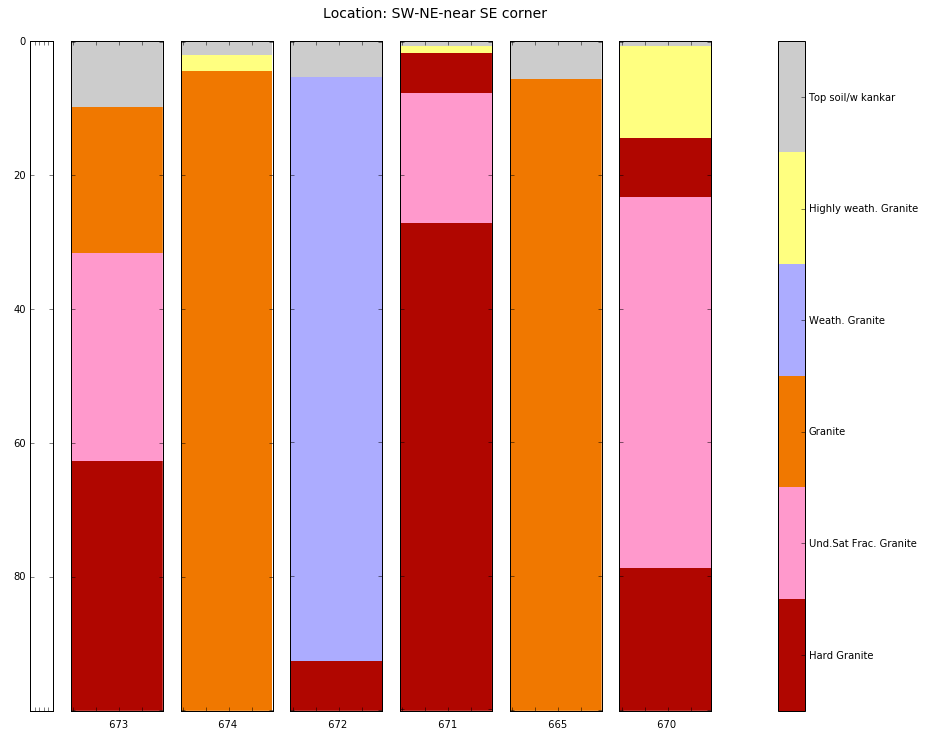

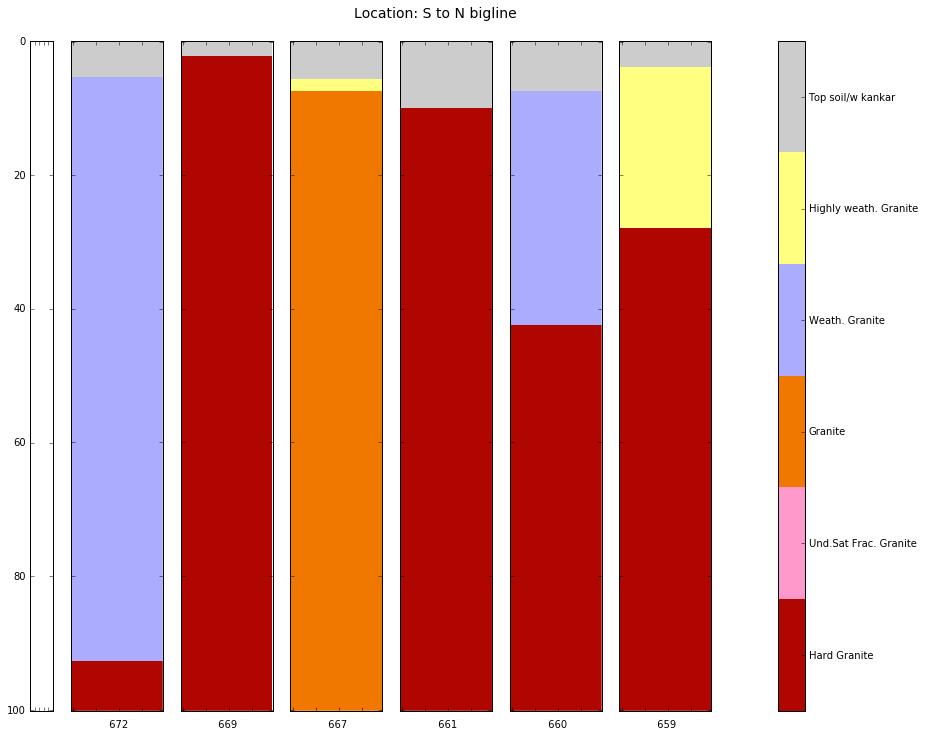

In [230]:
def facies_log_plot_multi(all_logs, facies_colors,facies_labels,Loc_numbers,fig_name):
    ncols=len(Loc_numbers)+2
    figsize=(1+(ncols-1)*2,12)
    width_ratios=[1]+[4 for r in range(ncols-1)] +[2]
    logs=all_logs[all_logs['Loc_number']==Loc_numbers[0]]
    #make sure logs are sorted by depth
#     print(logs)
    cmap_facies = colors.ListedColormap( facies_colors[0:len(facies_colors)], 'indexed')
#     print(cmap_facies)
    ztop=logs.Depth.min(); zbot=logs.Depth.max()    
    
#     print(cmap_facies)
    f, ax = plt.subplots(nrows=1, ncols=ncols, figsize=figsize,sharey=True)
    gs = gridspec.GridSpec(1, ncols, width_ratios=width_ratios)
    
    ax[0] = plt.subplot(gs[0])
    ax[0].set_ylim(ztop,zbot)
    ax[0].invert_yaxis()
    ax[0].set_xticklabels([])
    
    for i in range(1,ncols-1):
        logs=all_logs[all_logs['Loc_number']==Loc_numbers[i-1]]
        logs = logs.sort_values(by='Depth')
        ax[i] = plt.subplot(gs[i])
        cluster=np.repeat(np.expand_dims(logs['Lithology'].values.astype(np.int),1), 20, 1)
        im=ax[i].imshow(cluster, interpolation='none', aspect='auto',
                        cmap=cmap_facies,vmin=0,vmax=6)  
        ax[i].set_xlabel(' %s'%Loc_numbers[i-1])
        ax[i].set_yticklabels([])
        ax[i].set_xticklabels([])
    ax[-1].axis('off')
    divider = make_axes_locatable(ax[-1])
    cax = divider.append_axes("left", size="100%", pad=0.5)
    cbar=plt.colorbar(im, cax=cax)
#     cbar.set_label((11*' ').join(facies_labels[::-1]))
    cbar.set_ticks(np.arange(0.5,6,1)); 
#     cbar.set_ticklabels('')
    cbar.ax.invert_yaxis() 
    cbar.ax.set_yticklabels(facies_labels)
    f.suptitle('Location: %s'%fig_name[:-4], fontsize=14,y=0.94)
    f.savefig(fig_name)



    
allLoc_numbers=vesdf['VES No.'].values.astype(np.int)
sections=[
    [658,664,657,660,659],[663,664,657,662,661,667,666,671],
    [673,674,672,671,665,670],[672,669,667,661,660,659]
]
sec_image_names=['SW-NE-Twoards North','NW-SE-Across dist','SW-NE-near SE corner','S to N bigline']
for s,f in zip(sections,sec_image_names):
    facies_log_plot_multi(ldf, facies_colors,facies_labels,s,f+'.png')

In [172]:
logs=ldf[ldf['Loc_number']==657]
#make sure logs are sorted by depth
logs = logs.sort_values(by='Depth')
print(logs.head())
cmap_facies = colors.ListedColormap( facies_colors[0:len(facies_colors)], 'indexed')
print(cmap_facies)
ztop=logs.Depth.min(); zbot=logs.Depth.max()    
cluster=np.repeat(np.expand_dims(logs['Lithology'].values.astype(np.int),1), 100, 1)
print(cmap_facies)


   Depth Lithology  Loc_number
0    0.0         0       657.0
1    0.1         0       657.0
2    0.2         0       657.0
3    0.3         0       657.0
4    0.4         0       657.0


In [177]:
# cluster=np.array(cluster, dtype=int)
vs_df

NameError: name 'vs_df' is not defined

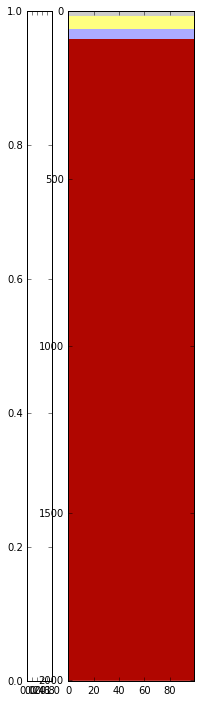

In [173]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(3, 12),sharey=True)
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 5]) 
ax[0] = plt.subplot(gs[0])
ax[1] = plt.subplot(gs[1])
im=ax[1].imshow(cluster, interpolation='none', aspect='auto',
                cmap=cmap_facies,vmin=0,vmax=6)    

In [112]:
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="20%", pad=0.05)
cbar=plt.colorbar(im, cax=cax)
cbar.set_label((11*' ').join(facies_labels[::-1]))
cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
cbar.ax.invert_yaxis() 

ax[0].set_ylim(ztop,zbot)
ax[0].invert_yaxis()

ax[1].set_xlabel('Layers')
for x in ax[0].get_xticklabels():
    x.set_visible(False)

ax[1].set_yticklabels([])
ax[1].set_xticklabels([])
f.suptitle('Location: %s'%Loc_number, fontsize=14,y=0.94)

array([0, 1, 2, 5], dtype=int64)

['#F5B041', '#F4D03F', '#DC7633', '#6E2C00', '#1B4F72', '#2E86C1']

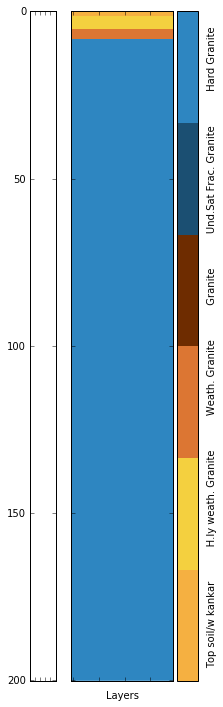

In [81]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(3, 12),sharey=True)
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 5]) 
ax[0] = plt.subplot(gs[0])
ax[1] = plt.subplot(gs[1])

im=ax[1].imshow(cluster, interpolation='none', aspect='auto',
                cmap=cmap_facies,vmin=0,vmax=len())

divider = make_axes_locatable(ax[1])

cax = divider.append_axes("right", size="20%", pad=0.05)
cbar=plt.colorbar(im, cax=cax)
cbar.set_label((11*' ').join(c))

cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')

ax[0].set_ylim(ztop,zbot)
ax[0].invert_yaxis()

ax[1].set_xlabel('Layers')
for x in ax[0].get_xticklabels():
    x.set_visible(False)

ax[1].set_yticklabels([])
ax[1].set_xticklabels([])
    
facies_colors[:len(facies_labels)]

In [55]:
facies_labels

['Top soil/w kankar',
 'H.ly weath. Granite',
 'Weath. Granite',
 'Granite',
 'Und.Sat Frac. Granite',
 'Hard Granite']

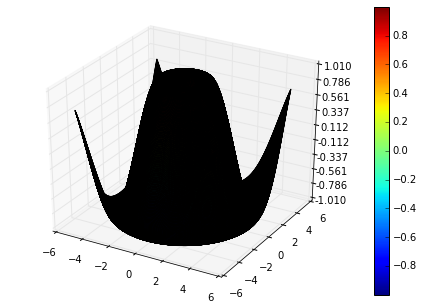

In [21]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FixedLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = Axes3D(fig)
X = np.arange(-5, 5, 0.025)
Y = np.arange(-5, 5, 0.025)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.jet)
ax.set_zlim3d(-1.01, 1.01)

ax.w_zaxis.set_major_locator(LinearLocator(10))
ax.w_zaxis.set_major_formatter(FormatStrFormatter('%.03f'))

fig.colorbar(surf)

plt.show()